# KD線交易策略教學
Author：余慶龍  
Establish Date：2021.7.25  
Last Modified Date：2021.7.25  

## Table of Contents
1. 介紹KD指標
2. 讀入股票資料  
3. 計算KD線
4. 繪出KD線與股價圖  
5. 策略1：邊界+突破
    1. 策略介紹  
    2. 策略買賣信號
    3. 繪製交易點
    4. 回溯檢驗
6. 策略2：背離
    1. 策略介紹  
    2. 策略買賣信號 

    
額外參考資料

# 1. 介紹KD指標
![](https://i.imgur.com/oTqCRR4.png)

## 2. 讀入股票資料

In [4]:
import pandas as pd
import numpy as np

file = "../../parse_data/data/splited/0050.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2019-12-27   97.60   98.15   97.60   98.00    2978
2019-12-30   98.00   98.25   97.60   97.80    3138
2019-12-31   97.10   97.20   96.95   96.95    4303
2020-01-02   97.05   98.00   97.05   97.65    4882
2020-01-03   98.30   98.70   97.00   97.65    6813
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[300 rows x 5 columns]


## 3. 計算KD線

In [19]:
# Define constants
KD_n = 9
upperBound = 80
lowerBound = 20

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

tmp['max_close'] = ticker['Close'].rolling(KD_n, min_periods=1).max()
tmp['min_close'] = ticker['Close'].rolling(KD_n, min_periods=1).min()

# RSV also called FastK
tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

data['k'] = np.zeros(ticker.shape[0])
data['d'] = np.zeros(ticker.shape[0])

# skip first day
# because RSV of first day is NaN
for i in range(1, tmp.shape[0]):
    
    # means data['k'][i]
    data.loc[(data.index[i], 'k')] = data['k'][i-1] * (2/3) + tmp['RSV'][i] * (1/3)
    data.loc[(data.index[i], 'd')] = data['d'][i-1] * (2/3) + data['k'][i] * (1/3)

print(data.head(10))

             Open   High    Low  Close  Volume          k          d
Date                                                                
2019-12-27  97.60  98.15  97.60  98.00    2978   0.000000   0.000000
2019-12-30  98.00  98.25  97.60  97.80    3138   0.000000   0.000000
2019-12-31  97.10  97.20  96.95  96.95    4303   0.000000   0.000000
2020-01-02  97.05  98.00  97.05  97.65    4882  22.222222   7.407407
2020-01-03  98.30  98.70  97.00  97.65    6813  37.037037  17.283951
2020-01-06  97.05  97.10  96.40  96.40    9321  24.691358  19.753086
2020-01-07  96.45  96.70  95.40  96.10    6328  16.460905  18.655693
2020-01-08  95.20  96.20  95.05  95.65    8516  10.973937  16.095107
2020-01-09  96.30  97.10  96.30  96.95    7163  25.755674  19.315296
2020-01-10  97.50  97.80  96.95  97.30    9071  42.751845  27.127479


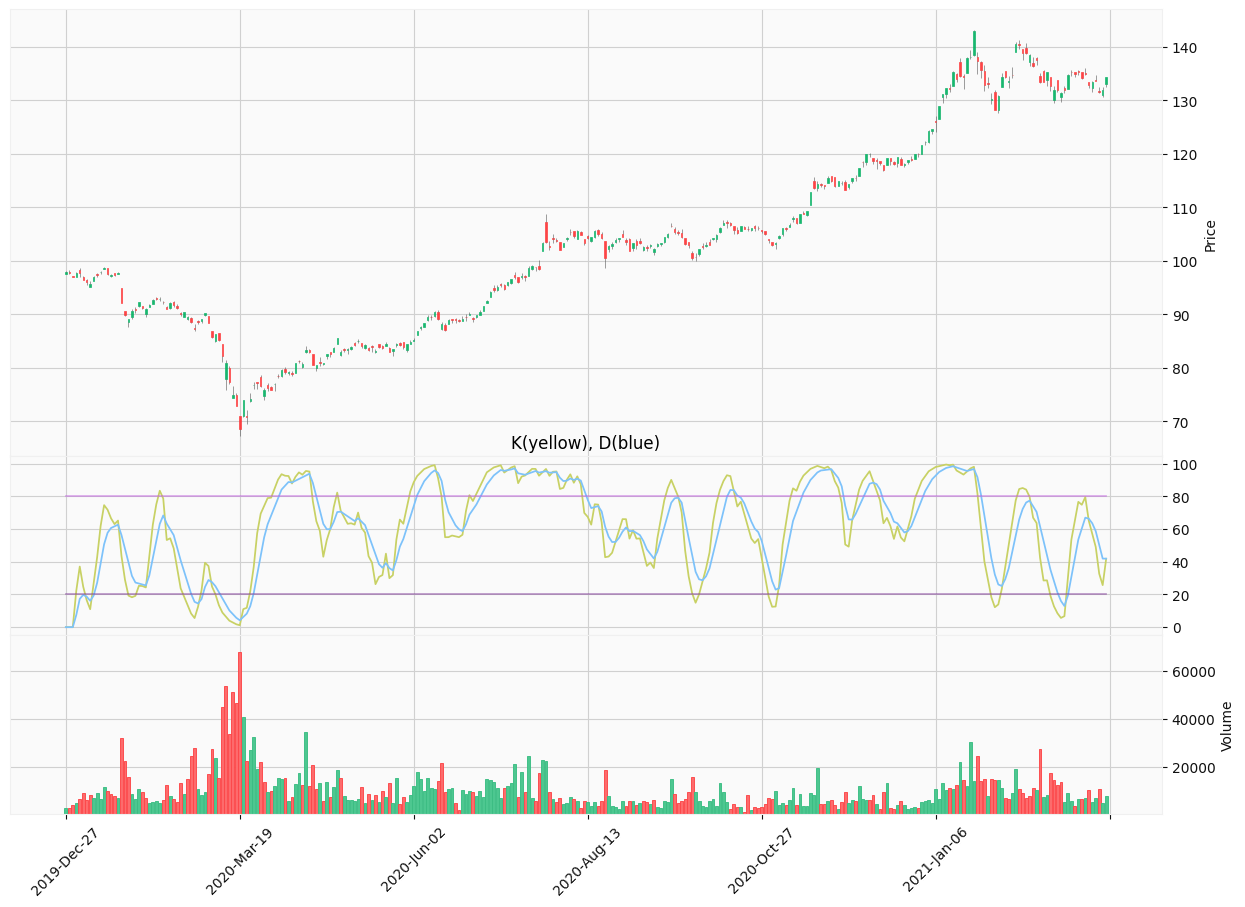

In [28]:
import mplfinance as mpf


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
]

# make the graph(plot)
mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=2,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)      

## 4. 策略1：界外+突破

### 4.1 界外+突破：策略介紹
利用K線在邊界之外並突破D線

買入：K線在20以下，向上突破D線  
賣出：K線在80以上，向下突破D線

### 4.2 界外+突破：策略買賣信號

In [21]:
# initialize 'buy' & 'sell' column by filling with 0
data['buy'] = np.zeros(ticker.shape[0])
data['sell'] = np.zeros(ticker.shape[0])


# skip first KD_n days
for i in range(KD_n, data.shape[0]):

    if(data['k'][i] < 20):
        
        # k upcross d
        if((data['k'][i-1] < data['d'][i-1]) and
           (data['k'][i]   > data['d'][i]) and
           (data['k'][i-1] < data['k'][i])):
            
            data.loc[(data.index[i], 'buy')] = 1
            print('buy  |', data.index[i])
    if(data['k'][i] > 80):
        
        # k downcross d
        if((data['k'][i-1] > data['d'][i-1]) and
           (data['k'][i]   < data['d'][i]) and
           (data['k'][i-1] > data['k'][i])):
            
            data.loc[(data.index[i], 'sell')] = 1
            print('sell |', data.index[i])

buy  | 2020-03-20 00:00:00
sell | 2020-04-13 00:00:00
sell | 2020-06-11 00:00:00
sell | 2020-07-10 00:00:00
sell | 2020-07-16 00:00:00
sell | 2020-07-24 00:00:00
sell | 2020-07-29 00:00:00
sell | 2020-08-03 00:00:00
sell | 2020-08-07 00:00:00
sell | 2020-08-11 00:00:00
sell | 2020-10-15 00:00:00
sell | 2020-11-24 00:00:00
sell | 2020-12-11 00:00:00
sell | 2021-01-14 00:00:00
sell | 2021-01-22 00:00:00


### 4.3 界外+突破：繪製交易點

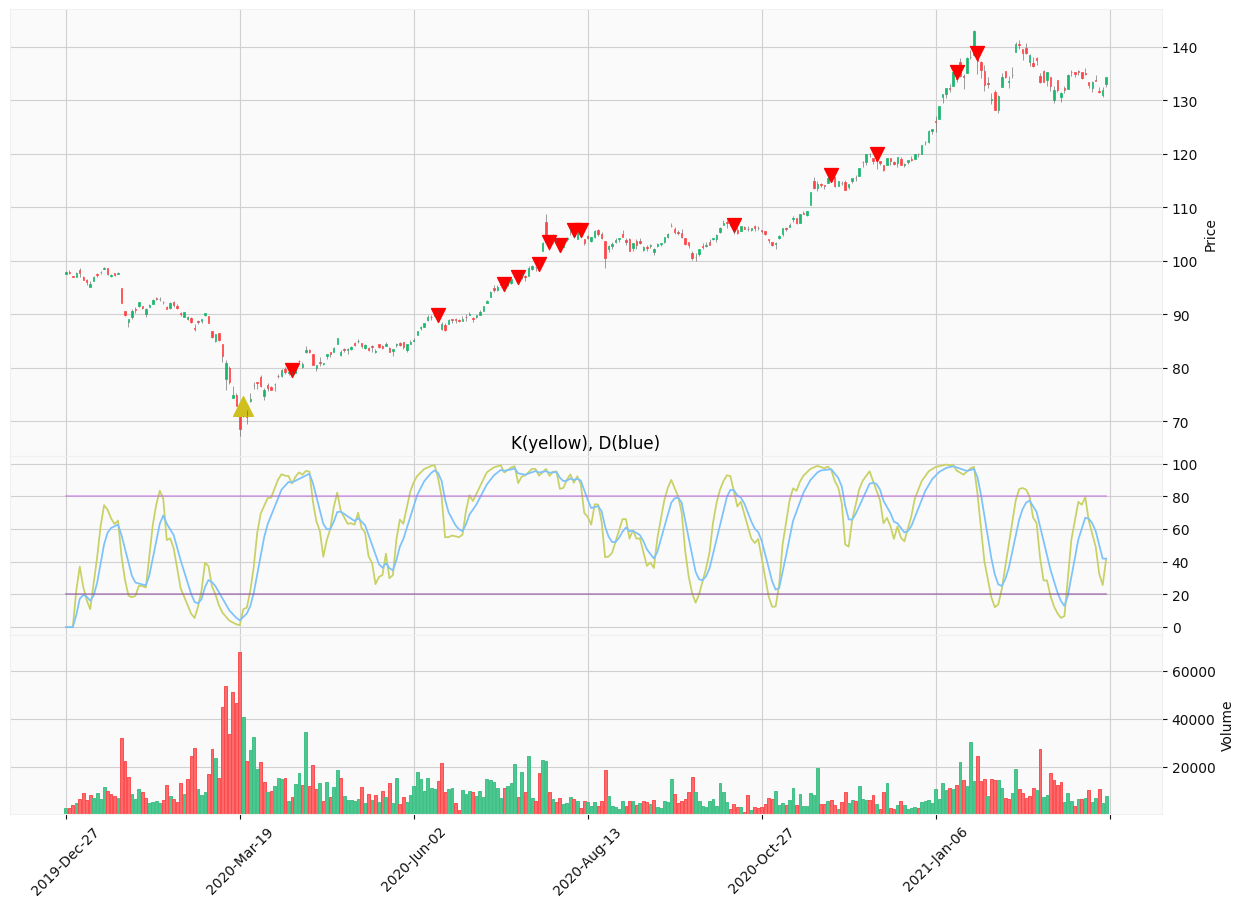

In [23]:
plots = []

# the position in graph
buy, sell = [], []

# Adjust the position to avoid signals block the lines
for index, row in data.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)


plots = [ 
    # Add the KD indicator to plot
    #     '#c8d164' is yellow
    #     '#7dc2fa' is blue
    mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
    mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
    # Add upperbound & lowerbound to plot
    mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
    mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
]

# Add trading point to plot
#    np.isnan(sell) determine the value is nan or not
#    count_nonzero(np.isnan(sell)) counts how many nan we have
#    if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))
if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=2,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)    

### 4.4 界外+突破：回溯檢驗

In [27]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in data.iterrows():
    
    if(row['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy ', row['Close'])
    
    # sell signal and we have some shares
    elif(row['sell'] == 1 and have_shares != 0):
        
        
        print('sell', row['Close'], "*" , have_shares)
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  74.0
sell 78.8 * 1

cumulative return rate : 6.486486486486487 %
accuracy : 100.0 %


---
Other reference：
* [TA-lib KD指標的計算](http://www.tadoc.org/indicator/STOCH.htm)
